Dynamical system given by:

$$dX_t = b(t,X_t,\alpha_t)dt + \sigma(t,X_t,\alpha_t)dW_t, \quad t \in [0,T].$$

Cost functional given by:

$$J[\alpha] = E\big[ \int_0^T f(t,X_t,\alpha_t)dt + g(X_T) \big].$$

Consider specific case: 

$b(t,x,\alpha) =  \alpha$, $\sigma(t,x,\alpha) = ax$, $f(t,x,\alpha) = c \alpha^2 + e x^2$, $g(X) = \epsilon x^2$, 

where $ a = 1$, $ c = 1$, $e=0$,  $\epsilon= \frac{1}{2}$. 

Take the initial condition $X_0 = 1$.


$$dX_t = \alpha_t dt +  X_t dW_t, \quad t \in [0,T],$$

$$J[\alpha] = E\big[ \int_0^T  \alpha_t^2 dt + \frac{1}{2} X_T^2 \big].$$


In [7]:
import numpy as np

#model params
a = 1
c = 1
e = 0
eps = .5

#model functions
def b(t,X,α):
    return α

def σ(t,X,α):
    return a*X

def f(t,X,α):
    return c*α**2 + e*X**2

def g(X):
    return eps*X**2

$V(t,x) := E\big[ \int_t^T f(s,X_s,\alpha^*_s)ds \big | X_t = x]$ solves the HJB equation:

\begin{align}
 & V_t + \inf_{\alpha} \big[ b(t,x,\alpha) V_x + \frac{1}{2} \sigma(t,x,\alpha)^2 V_{xx} + f(t,x,\alpha)  \big] = 0, \\
 & V(T,x) = g(x).
\end{align}

The minimizer, $\alpha^* = \alpha^*\big(t,x,V_x(t,x),V_{xx}(t,x)\big)$ is given by the first order condition: 

$$\frac{\partial}{\partial \alpha} \big[ b(t,x,\alpha) V_x + \frac{1}{2} \sigma(t,x,\alpha)^2 V_{xx} + f(t,x,\alpha) \big] = 0.$$

Now using $b(t,x,\alpha) =  \alpha$, $\sigma(t,x,\alpha) = ax$, and $f(t,x,\alpha) = c \alpha^2 + e x^2$ obtain:

\begin{align}
 & \frac{\partial}{\partial \alpha} \big[ b(t,x,\alpha) V_x + \frac{1}{2} \sigma(t,x,\alpha)^2 V_{xx} + f(t,x,\alpha) \big] = 0  & \Rightarrow \\
 & \frac{\partial}{\partial \alpha} \big[ \alpha V_x + \frac{1}{2} a^2 x^2 V_{xx} + c \alpha^2 + e x^2 \big] = 0 & \Rightarrow \\
 & V_x + 2c\alpha^*  = 0 & \Rightarrow \\
 & \alpha^* = -\frac{1}{2c} V_x. \\
\end{align}

So the HJB equation
\begin{align}
 & V_t +  b(t,x,\alpha^*) V_x + \frac{1}{2} \sigma(t,x,\alpha^*)^2 V_{xx} + f(t,x,\alpha^*)   = 0, \\
 & V(T,x) = g(x).
\end{align}
becomes
\begin{align}
 & V_t -  \frac{1}{2c} V_x^2 + \frac{1}{2} a^2 x^2 V_{xx} + \frac{1}{4c^2} V_x^2 + ex^2    = 0, \\
 & V(T,x) = \epsilon x^2.
\end{align}

Let $V^{NN}(t,x ; \theta)$ be an NN with parameters $\theta$. We will approximate the HJB by minimizing the loss function:

$$ L =   \int_{\mathbb{R}} \int_0^T \Big[ V^{NN}_t -  \frac{1}{2c} (V^{NN}_x)^2 + \frac{1}{2} a^2 x^2 V^{NN}_{xx} + \frac{1}{4c^2} (V^{NN}_x)^2 + ex^2 \Big]^2dt dx   + \lambda \int_{\mathbb{R}} \big( V^{NN}(T,x) - \epsilon x^2 \big)^2 dx $$

with respect to $\theta$ to get some approximate value function $V^{NN}(t,x ; \theta^*)$.


In [8]:
import torch
from torch import nn

In [9]:
class Model(nn.Module):
    #Standard NN
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( 
            nn.Linear(2,64),   #2 x 64 operation. i.e. maps n x 2 to n x 64 via: x maps to xA + b
            nn.Sigmoid(),      #activation 
            nn.Linear(64, 64), #maps n x 64 to n x 64
            nn.Sigmoid(),      #activation
            nn.Linear(64, 1),  #maps n x 64 to n x 1
            )
    def forward(self,z):
        return self.net(z)

Instantiate $V^{NN}$

Compute loss for a given $V^{NN}$.

Note in reality, we will do the following:

1. Sample $N_{batch}$ points $(t_i, x_i)$ from $[0,T] \times [-L,L]$.
2. On this batch compute an approximate loss function:

$$ \hat{L} =   \frac{1}{N_{batch}}\sum_{i=1}^{N_{batch}} \Big[ V^{NN}_t(t_i,x_i) -  \frac{1}{2c} V^{NN}_x(t_i,x_i)^2 + \frac{1}{2} a^2 x_i^2 V^{NN}_{xx}(t_i,x_i) + \frac{1}{4c^2} V^{NN}_x(t_i,x_i)^2 + ex_i^2 \Big]^2   + \lambda \frac{1}{N_{batch}}\sum_{i=1}^{N_{batch}} \big( V^{NN}(T,x_i) - \epsilon x_i^2 \big)^2 dx $$

3. Do an optimization step for the parameters of the NN with respect to $\hat{L}$.

In [14]:
L = 10
T = 1

N_batch = 2**10

def get_loss(V_NN):
    #Randomly sample N_batch (x,t) points. Call it xt = (x_i,t_i)_i=1^N_batch
    x = torch.distributions.uniform.Uniform(-L, L).sample((N_batch, 1))
    t = torch.distributions.uniform.Uniform(0, T).sample((N_batch, 1))
    T_f = torch.ones(t.shape)*T


    x.requires_grad = True
    t.requires_grad = True

    xt = torch.cat((x,t),1)
    xT = torch.cat((x,T_f),1)
    
    #V^NN along the sample (x_i,t_i)
    VNN = V_NN(xt)
    #V^NN at terminal time T:
    VNNT = V_NN(xT)
    
    #Interior derivatives:
    VNN_t = torch.autograd.grad(VNN.sum(),t,create_graph = True)[0]
    VNN_x = torch.autograd.grad(VNN.sum(),x,create_graph = True)[0]
    VNN_xx = torch.autograd.grad(VNN_x.sum(),x,create_graph = True)[0]
    print(VNN_x)

    
    #weighted loss
    λ = 1
    L1 = torch.mean((VNN_t - .25/c*VNN_x**2 + .5*a*x**2*VNN_xx + e*x**2)**2)
    L2 = torch.mean((VNNT - eps*x**2)**2)
    Loss = L1 + λ*L2
    
    return Loss
    


Training

In [27]:
get_loss(V_NN).backward()

In [15]:
opt = torch.optim.Adam(V_NN.parameters(), lr=.01) #may change lr over time depending on training

N_epoch = 10000

for n in range(0,N_epoch):
    
    Loss = get_loss(V_NN)
    
    Loss.backward()
    opt.step()
    opt.zero_grad()
    
    if n%100 == 0:
        print("Epoch: " + str(n))
        print("Loss: " + str(round(Loss.detach().item(),3)))

tensor([[0.0021],
        [0.0017],
        [0.0071],
        ...,
        [0.0051],
        [0.0072],
        [0.0025]], grad_fn=<SliceBackward0>)
Epoch: 0
Loss: 506.693
tensor([[0.0002],
        [0.0016],
        [0.0006],
        ...,
        [0.0030],
        [0.0015],
        [0.0022]], grad_fn=<SliceBackward0>)
tensor([[-0.0018],
        [ 0.0021],
        [ 0.0016],
        ...,
        [-0.0013],
        [ 0.0004],
        [-0.0013]], grad_fn=<SliceBackward0>)
tensor([[-0.0047],
        [-0.0003],
        [-0.0021],
        ...,
        [ 0.0005],
        [-0.0036],
        [-0.0005]], grad_fn=<SliceBackward0>)
tensor([[ 0.0002],
        [-0.0141],
        [ 0.0002],
        ...,
        [-0.0006],
        [-0.0008],
        [-0.0053]], grad_fn=<SliceBackward0>)
tensor([[-0.0110],
        [-0.0008],
        [-0.0133],
        ...,
        [-0.0124],
        [-0.0006],
        [-0.0047]], grad_fn=<SliceBackward0>)
tensor([[-0.0009],
        [-0.0065],
        [-0.0145],
        

tensor([[-0.0056],
        [-0.0051],
        [-0.0037],
        ...,
        [-0.0055],
        [-0.0024],
        [ 0.0002]], grad_fn=<SliceBackward0>)
tensor([[-0.0013],
        [ 0.0005],
        [-0.0020],
        ...,
        [-0.0016],
        [ 0.0003],
        [-0.0049]], grad_fn=<SliceBackward0>)
tensor([[-0.0042],
        [-0.0034],
        [-0.0018],
        ...,
        [-0.0022],
        [-0.0027],
        [-0.0064]], grad_fn=<SliceBackward0>)
tensor([[-6.5052e-03],
        [ 6.3328e-04],
        [ 6.7303e-04],
        ...,
        [-6.4242e-03],
        [-6.9506e-03],
        [ 8.6081e-05]], grad_fn=<SliceBackward0>)
tensor([[ 0.0006],
        [-0.0021],
        [-0.0031],
        ...,
        [-0.0063],
        [ 0.0007],
        [-0.0050]], grad_fn=<SliceBackward0>)
tensor([[-0.0036],
        [-0.0029],
        [-0.0091],
        ...,
        [-0.0033],
        [-0.0026],
        [-0.0096]], grad_fn=<SliceBackward0>)
tensor([[-0.0105],
        [ 0.0009],
        [-0.00

tensor([[ 0.0053],
        [-0.0350],
        [ 0.1042],
        ...,
        [-0.0028],
        [-0.0251],
        [-0.0040]], grad_fn=<SliceBackward0>)
tensor([[-0.0041],
        [ 0.0119],
        [-0.0090],
        ...,
        [-0.0863],
        [ 0.0140],
        [-0.0059]], grad_fn=<SliceBackward0>)
tensor([[-0.1780],
        [-0.0122],
        [ 0.3316],
        ...,
        [ 0.0207],
        [ 0.0662],
        [-0.0074]], grad_fn=<SliceBackward0>)
tensor([[-0.0040],
        [ 0.0031],
        [-0.1065],
        ...,
        [-0.0569],
        [ 0.0870],
        [-0.2053]], grad_fn=<SliceBackward0>)
tensor([[ 0.2792],
        [-0.0519],
        [-0.2141],
        ...,
        [-0.0054],
        [-0.0105],
        [-0.1860]], grad_fn=<SliceBackward0>)
tensor([[-0.1826],
        [ 0.0762],
        [-0.1025],
        ...,
        [ 0.2458],
        [ 0.2350],
        [-0.1296]], grad_fn=<SliceBackward0>)
tensor([[-0.0542],
        [ 0.0063],
        [-0.1539],
        ...,
      

tensor([[-0.3840],
        [-0.0966],
        [-0.0909],
        ...,
        [-0.0425],
        [-0.5551],
        [ 0.8429]], grad_fn=<SliceBackward0>)
tensor([[-0.0185],
        [ 0.1722],
        [ 0.8259],
        ...,
        [-0.4478],
        [ 0.2711],
        [-0.0144]], grad_fn=<SliceBackward0>)
tensor([[-0.1447],
        [-0.0331],
        [-0.0084],
        ...,
        [-0.0074],
        [ 0.1685],
        [-0.0158]], grad_fn=<SliceBackward0>)
tensor([[-0.0732],
        [ 0.0140],
        [ 0.8837],
        ...,
        [ 0.3622],
        [ 0.2688],
        [-0.2498]], grad_fn=<SliceBackward0>)
tensor([[ 0.5682],
        [ 0.6198],
        [-0.3024],
        ...,
        [-0.4802],
        [ 0.7866],
        [-0.1578]], grad_fn=<SliceBackward0>)
tensor([[ 0.2734],
        [-0.0210],
        [-0.0223],
        ...,
        [ 1.1408],
        [ 0.2221],
        [-0.4920]], grad_fn=<SliceBackward0>)
tensor([[ 1.2551],
        [-0.1606],
        [ 0.0074],
        ...,
      

tensor([[ 1.8338],
        [ 0.2014],
        [-0.4482],
        ...,
        [ 0.6095],
        [-0.3552],
        [-0.0746]], grad_fn=<SliceBackward0>)
tensor([[-0.1405],
        [ 0.2976],
        [ 1.6100],
        ...,
        [ 0.7418],
        [ 2.0610],
        [ 2.2648]], grad_fn=<SliceBackward0>)
tensor([[-0.6715],
        [ 0.4006],
        [-0.1747],
        ...,
        [-0.4577],
        [ 0.2143],
        [ 0.7364]], grad_fn=<SliceBackward0>)
tensor([[-0.5188],
        [-0.0204],
        [ 0.5944],
        ...,
        [-0.8553],
        [ 0.9026],
        [-0.4581]], grad_fn=<SliceBackward0>)
tensor([[-0.3525],
        [-0.3474],
        [-0.1480],
        ...,
        [-0.6908],
        [-0.0953],
        [-0.8595]], grad_fn=<SliceBackward0>)
tensor([[ 0.6314],
        [-0.2842],
        [-0.2875],
        ...,
        [-0.1809],
        [-0.5490],
        [ 0.7701]], grad_fn=<SliceBackward0>)
tensor([[-0.2078],
        [ 0.6689],
        [ 0.2423],
        ...,
      

tensor([[-0.4554],
        [ 1.5455],
        [ 0.1583],
        ...,
        [-0.8009],
        [-0.8008],
        [ 0.9259]], grad_fn=<SliceBackward0>)
tensor([[-0.4653],
        [ 0.1174],
        [ 0.4316],
        ...,
        [ 2.2694],
        [-0.8284],
        [ 2.0820]], grad_fn=<SliceBackward0>)
tensor([[-0.8721],
        [ 2.4498],
        [ 0.9451],
        ...,
        [-0.6027],
        [ 0.8265],
        [-0.8697]], grad_fn=<SliceBackward0>)
tensor([[-0.3849],
        [-0.2678],
        [ 1.3031],
        ...,
        [-0.4917],
        [ 1.0263],
        [ 1.7267]], grad_fn=<SliceBackward0>)
tensor([[ 1.6697],
        [ 3.3978],
        [ 1.2400],
        ...,
        [-0.3210],
        [-0.3923],
        [ 3.8132]], grad_fn=<SliceBackward0>)
tensor([[ 1.9526],
        [ 1.5184],
        [ 0.3023],
        ...,
        [-0.4994],
        [-0.8326],
        [-1.1804]], grad_fn=<SliceBackward0>)
tensor([[ 1.0815],
        [ 0.9712],
        [ 0.6087],
        ...,
      

tensor([[-5.6361e-01],
        [-6.0146e-01],
        [ 1.6888e+00],
        ...,
        [ 1.3576e-05],
        [ 1.4362e+00],
        [ 1.0610e+00]], grad_fn=<SliceBackward0>)
tensor([[ 4.0386],
        [-1.0528],
        [ 1.8843],
        ...,
        [-0.1263],
        [-0.5471],
        [-0.4894]], grad_fn=<SliceBackward0>)
tensor([[ 0.6995],
        [-0.4116],
        [ 2.6715],
        ...,
        [ 1.2484],
        [-0.0143],
        [-0.9419]], grad_fn=<SliceBackward0>)


KeyboardInterrupt: 

True $\alpha^*$ given by:

In [17]:
def alpha_star(x,t):
    return -x*eps*np.exp(1)/(np.exp(t)- eps*np.exp(t) + eps*np.exp(1))

Plotting

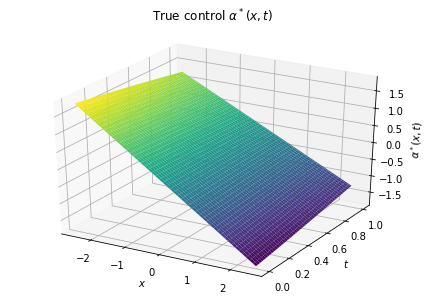

In [18]:
import matplotlib.pyplot as plt

x = np.linspace(-L/4,L/4, 200)
t = np.linspace(0, T, 100)
x_grid, t_grid = np.meshgrid(x, t)

alpha_plt = alpha_star(x_grid,t_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
ax.set_zlabel(r'$\alpha^*(x,t)$')
ax.plot_surface(x_grid, t_grid, alpha_plt, cmap='viridis')
plt.tight_layout()
plt.title(r'True control $\alpha^*(x,t)$')
plt.show()

Use $\alpha^{approx} = -\frac{1}{2c} V^{NN}_{x}$ and compare with $\alpha^*$.

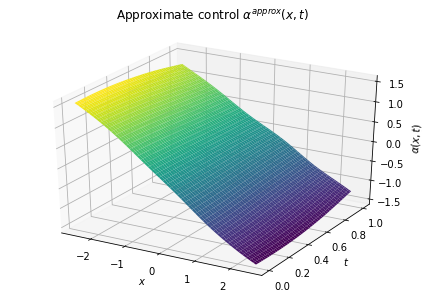

In [19]:
x = torch.linspace(-L/4, L/4, 200)
t = torch.linspace(0, T, 100)
x.requires_grad = True

xt = torch.stack(torch.meshgrid(x, t),dim=2)

VNN = V_NN(xt).squeeze()
VNN_x = torch.empty(VNN.shape)
for i in range(0,100):
    VNN_x[:,i] = torch.autograd.grad(VNN[:,i].sum(),x,create_graph = True)[0]

alpha_approx = -.5/c*VNN_x
alpha_approx = alpha_approx.t()

#plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
ax.set_zlabel(r'$\alpha(x,t)$')
ax.plot_surface(x_grid,t_grid, alpha_approx.detach().numpy(), cmap='viridis')
plt.tight_layout()
plt.title(r'Approximate control $\alpha^{approx}(x,t)$')
plt.show()

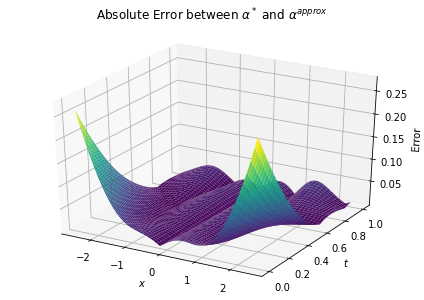

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
ax.set_zlabel(r'Error')
ax.plot_surface(x_grid,t_grid, np.abs(alpha_approx.detach().numpy()-alpha_plt), cmap='viridis')
plt.tight_layout()
plt.title(r'Absolute Error between $\alpha^*$ and $\alpha^{approx}$')
plt.show()
